## Data Loading

In [1]:
# Load Dataset
import tensorflow as tf

# Balance
train_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/train'
val_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/val'
test_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/test'

# Define parameters
BATCH_SIZE = 32
IMG_SIZE = (256, 256)  # Image dimensions

# Load the train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    shuffle=True,
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMG_SIZE)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                  shuffle=True,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   shuffle=False,
                                                                   batch_size=BATCH_SIZE,
                                                                   image_size=IMG_SIZE)

Found 9973 files belonging to 10 classes.
Found 1595 files belonging to 10 classes.
Found 1607 files belonging to 10 classes.


In [2]:
# Print class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [3]:
# Define normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to each dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [4]:
# Define input shape, number of classes and batch size
input_shape = (256, 256, 3)
num_classes = 10  
batch_size = 32

## Hyperparameter Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the Squeeze-and-Excitation (SE) Block
class SEBlock(layers.Layer):
    def __init__(self, filters, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dense1 = layers.Dense(filters // reduction, activation='relu')
        self.dense2 = layers.Dense(filters, activation='sigmoid')

    def call(self, inputs):
        se = self.global_avg_pool(inputs)
        se = self.dense1(se)
        se = self.dense2(se)
        se = layers.Reshape((1, 1, se.shape[-1]))(se)
        return inputs * se

# Define the model as a HyperModel function for tuning
def build_tomato_disease_cnn(hp):
    inputs = layers.Input(shape=input_shape)
    # First convolutional layer
    x = layers.Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32), 
        kernel_size=(3, 3), activation='relu'
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Second convolutional layer with SE Block
    conv2_filters = hp.Int('conv2_filters', min_value=64, max_value=256, step=64)
    x = layers.Conv2D(
        filters=conv2_filters, 
        kernel_size=(3, 3), activation='relu'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = SEBlock(filters=conv2_filters)(x)
    # Third convolutional layer
    x = layers.Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64), 
        kernel_size=(3, 3), activation='relu'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Fourth convolutional layer
    x = layers.Conv2D(
        filters=hp.Int('conv4_filters', min_value=128, max_value=512, step=128), 
        kernel_size=(3, 3), activation='relu', padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    # Fifth convolutional layer
    x = layers.Conv2D(
        filters=hp.Int('conv5_filters', min_value=128, max_value=512, step=128), 
        kernel_size=(3, 3), activation='relu', padding='same'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    # Global Average Pooling and Dense Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)
    x = layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64), 
        activation='relu'
    )(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_tomato_disease_cnn,
    objective='val_accuracy',
    max_trials=10, 
    executions_per_trial=1, 
    directory='tuner_results',
    project_name='tomato_disease_tuning'
)

# Define early stopping to prevent overfitting during tuning
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Start the tuning process
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best number of filters in conv1 layer: {best_hps.get('conv1_filters')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 06m 09s]
val_accuracy: 0.9617555141448975

Best val_accuracy So Far: 0.9805642366409302
Total elapsed time: 01h 26m 18s
Best number of filters in conv1 layer: 32
Best learning rate: 0.0001


In [6]:
# Retrieve and display the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Print each hyperparameter with its best value
print("Best hyperparameters found:")
print(f"Conv1 Filters: {best_hps.get('conv1_filters')}")
print(f"Conv2 Filters: {best_hps.get('conv2_filters')}")
print(f"Conv3 Filters: {best_hps.get('conv3_filters')}")
print(f"Conv4 Filters: {best_hps.get('conv4_filters')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Best hyperparameters found:
Conv1 Filters: 32
Conv2 Filters: 192
Conv3 Filters: 128
Conv4 Filters: 512
Dense Units: 256
Dropout Rate: 0.6000000000000001
Learning Rate: 0.0001


In [ ]:
# Build the model with the best hyperparameters
cnn_model_tuning = tuner.hypermodel.build(best_hps)

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model on the dataset
history = cnn_model_tuning.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]  
)

Epoch 1/30
  2/312 ━━━━━━━━━━━━━━━━━━━━ 23s 77ms/step - accuracy: 0.0938 - loss: 3.2042 

I0000 00:00:1730892132.656361      71 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads



312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4869 - loss: 1.5508

I0000 00:00:1730892165.861378      73 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_slice_fusion_3', 8 bytes spill stores, 8 bytes spill loads



312/312 ━━━━━━━━━━━━━━━━━━━━ 45s 114ms/step - accuracy: 0.4873 - loss: 1.5495 - val_accuracy: 0.1831 - val_loss: 4.1525 - learning_rate: 1.0000e-04
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.7475 - loss: 0.7497 - val_accuracy: 0.6476 - val_loss: 1.1240 - learning_rate: 1.0000e-04
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8203 - loss: 0.5404 - val_accuracy: 0.8771 - val_loss: 0.3475 - learning_rate: 1.0000e-04
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8572 - loss: 0.4311 - val_accuracy: 0.9103 - val_loss: 0.2665 - learning_rate: 1.0000e-04
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8793 - loss: 0.3680 - val_accuracy: 0.8934 - val_loss: 0.3065 - learning_rate: 1.0000e-04
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 0.8902 - loss: 0.3262 - val_accuracy: 0.8194 - val_loss: 0.5225 - learning_rate: 1.0000e-04
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accura

In [8]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = cnn_model_tuning.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9840 - loss: 0.0500
Test accuracy: 0.9863098859786987
Test loss: 0.043541960418224335


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate predictions for the test dataset
predictions = cnn_model_tuning.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)  # Get the predicted class labels
true_classes = tf.concat([y for x, y in test_dataset], axis=0)  # True labels from the test dataset

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Precision: 0.9864530757441204
Recall: 0.9863098942128189
F1 Score: 0.9863268859051489


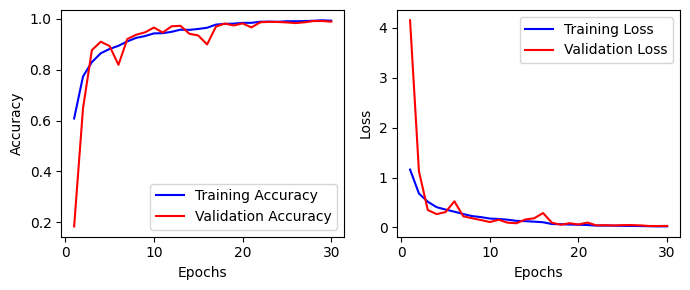

In [10]:
import matplotlib.pyplot as plt

# Retrieve model training and validation metrics from the history object
acc2 = history.history['accuracy'] #training accuracy
val_acc = history.history['val_accuracy'] #validation accuracy
loss2 = history.history['loss'] #training loss
val_loss = history.history['val_loss'] #validation loss

# Define the range for epochs
epochs = range(1,len(acc2)+1)

# Plot training and validation accuracy on the first subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# Plot training and validation accuracy on the first subplot
axes[0].plot(epochs, acc2, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot training and validation loss on the second subplot
axes[1].plot(epochs, loss2, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test dataset
y_pred = cnn_model_tuning.predict(test_dataset)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)  

# Get true labels from test_dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate classification report with meaningful class names
report = classification_report(test_labels, y_pred_classes, target_names=class_names)

print(report)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.98      0.99      0.98       214
                        Tomato_Early_blight       0.96      0.98      0.97       100
                         Tomato_Late_blight       0.99      0.98      0.98       191
                           Tomato_Leaf_Mold       0.99      1.00      0.99        96
                  Tomato_Septoria_leaf_spot       0.98      0.98      0.98       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.98      0.99      0.99       169
                        Tomato__Target_Spot       1.00      0.97      0.99       141
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.99      0.98      0.99       321
                Tomato__Tomato_mosaic_virus       0.95      1.00      0.97        38
                             Tomato_healthy       1.00      1.00      1.00       159

                       

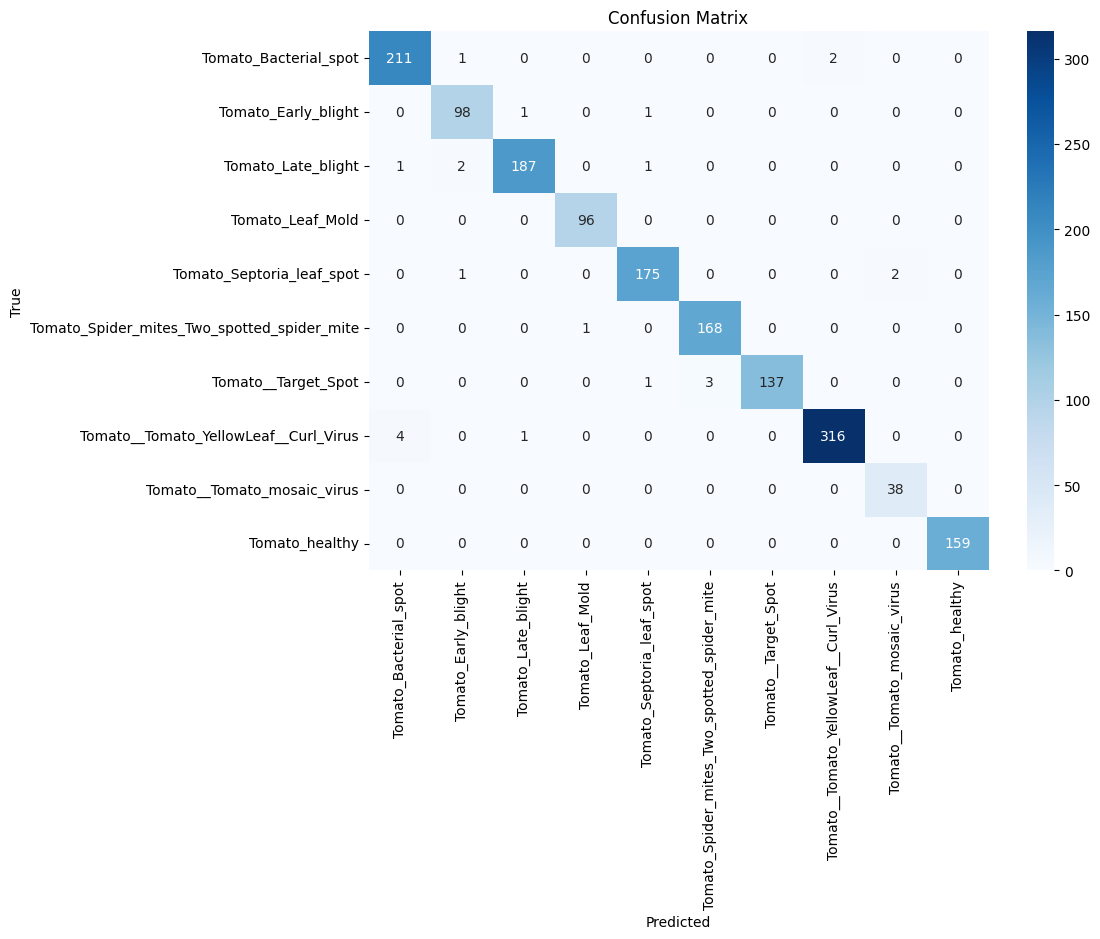

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
cnn_model_tuning.save('/kaggle/working/cnn_model.h5')  # Save to Kaggle's working directory